## IBM Capstone Project Week 3- Segmenting and Clustering Neighborhood Data

# Part 1

## ***1. Necessary Packages***

In [1]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as bs
import html
import pandas as pd

## ***2. Scrape Toronto Neighborhood Data***

In [2]:
t_url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'
#opening the connection and grabbing the url
u_client = uReq(t_url)
page_html = u_client.read()
u_client.close()

#html parsing
page_soup = bs( page_html, "html")

#get the table of neighborhoods in the page by inspecting the html page structure and finding the layout tags
page_table = page_soup.table
#'th' contains the table column information
tags = page_table.find_all('th')
#extract column names and put it in a list
columns = [th.text.strip() for th in tags]
print(columns)

#create the empty dataframe to fill in
toronto_df = pd.DataFrame(columns=columns)

# 'tr' contains the rows of the table 
rows = page_table.find_all('tr')

#loop through rows and fill in toronto_df

for t in rows:
    row_info = t.find_all('td')
    if not row_info: #The first row with colum headings 'th' need to be skipped
        continue
    post_code, borough, neig = [td.text.strip() for td in row_info ]
    
    if borough != "Not assigned":  #Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
        
        toronto_df = toronto_df.append({'Postcode': post_code, 'Borough': borough, 'Neighbourhood': neig}, ignore_index=True)


#Check Neighbourhood Merge
print(toronto_df.loc[toronto_df['Postcode']=='M4B'])

toronto_df.head()

['Postcode', 'Borough', 'Neighbourhood']
   Postcode    Borough     Neighbourhood
10      M4B  East York  Woodbine Gardens
11      M4B  East York     Parkview Hill


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


## ***3. Merge Neighbourhood with Same Postal Code***

In [3]:
toronto_df['Neighbourhood'] = toronto_df.groupby('Postcode')['Neighbourhood'].transform(lambda x: "%s" % ', '.join(x)).values
toronto_df = toronto_df.drop_duplicates().reset_index(drop=True)

#Check Merge
toronto_df.loc[toronto_df['Postcode']=='M4B']

,Postcode,Borough,Neighbourhood
8,M4B,East York,"Woodbine Gardens, Parkview Hill"


## ***4. Replace Not Assigned Neighbourhoods with Borough Name***

In [4]:
toronto_df['Neighbourhood'].replace("Not assigned", toronto_df['Borough'], inplace=True)
#Check if any not assigned neighbourhood left
print(len(toronto_df.loc[toronto_df['Neighbourhood']=="Not assigned"]))
toronto_df.head()


0


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


In [5]:
toronto_df.shape

(103, 3)

# Part 2

## ***5. Get Latitude and Longitude***

### ***Part 2 of the assignment***

In [6]:
#!pip install geocoder
!pip install geopandas
!pip install geopy

     |████████████████████████████████| 931kB 12.4MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 21.2MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 36.3MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 18.3MB/s eta 0:00:01


In [7]:

from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')

toronto_df['ADDRESS']=toronto_df['Postcode']+','+toronto_df['Borough']+',Toronto'
from geopy.extra.rate_limiter import RateLimiter

# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=0.5)
# 2- - create location column
toronto_df['location'] = toronto_df['ADDRESS'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
toronto_df['point'] = toronto_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
toronto_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(toronto_df['point'].tolist(), index=toronto_df.index)

In [8]:
toronto_df.head()

,Postcode,Borough,Neighbourhood,ADDRESS,location,point,latitude,longitude,altitude
0,M3A,North York,Parkwoods,"M3A,North York,Toronto","(North York, Toronto, Golden Horseshoe, Ontari...","(43.7543263, -79.44911696639593, 0.0)",43.754326,-79.449117,0.0
1,M4A,North York,Victoria Village,"M4A,North York,Toronto",None,None,NaN,NaN,NaN
2,M5A,Downtown Toronto,Harbourfront,"M5A,Downtown Toronto,Toronto",None,None,NaN,NaN,NaN
3,M6A,North York,"Lawrence Heights, Lawrence Manor","M6A,North York,Toronto",None,None,NaN,NaN,NaN
4,M7A,Downtown Toronto,Queen's Park,"M7A,Downtown Toronto,Toronto","(Downtown Yonge, Toronto Centre, Old Toronto, ...","(43.6563221, -79.3809161, 0.0)",43.656322,-79.380916,0.0


In [9]:
toronto_df[toronto_df['location'].isna()].shape[0]

81

## ***The API is failed to retrieve most of the coordinates hence the csv file is used***

In [10]:


url_csv = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(url_csv)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
#dropped the unnecessary columns added previously during the API call trial
toronto_df.drop(columns=['ADDRESS', 'location','point','latitude','longitude','altitude'], inplace=True)
df_toronto = toronto_df.join(df_coordinates.set_index('Postal Code'), on='Postcode')

In [12]:
#check if the coordinates joined correctly
df_toronto.loc[df_toronto['Postcode']=='M1J']

,Postcode,Borough,Neighbourhood,Latitude,Longitude
32,M1J,Scarborough,Scarborough Village,43.744734,-79.239476


In [13]:
#rename as Postal Code
df_toronto.rename(columns = {'Postcode':'Postal Code'}, inplace = True)
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


# Part 3

## ***6. Exploration and Clustering of Toronto Neighbourhoods***

## ***6.1 Exploration***

### ***Part 3 of the assignment***

In [14]:
import numpy as np

!conda install -c conda-forge folium=0.5.0 --yes
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    ------------------------------------------------------------
                       

## Chose to work with all boroughs

In [15]:
Toronto = df_toronto
print(Toronto.shape)
Toronto.head()


(103, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


In [16]:
#get the coordinates of Toronto to create map of Toronto
location = locator.geocode('Toronto')
latitude = location.latitude
longitude = location.longitude
print('The latitude and longitude of Toronto are {},{}.'.format(latitude,longitude))

The latitude and longitude of Toronto are 43.653963,-79.387207.


In [17]:

#get the map of Toronto using folium
Toronto_Map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for latitude, longitude, label in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=8,
        popup=label,
        color='pink',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.8,
        parse_html=False).add_to(Toronto_Map)  
    
Toronto_Map

## Forsquare Exploration

In [18]:
CLIENT_ID = '0T2Y44AI2MDDOSJL0B0XBEOOB55EZXFCZ2TOZL2OMHBPNB5D' #Foursquare ID
CLIENT_SECRET = 'KOIVJ2KYDOFIZW2E2XF4X15BBSQDJACBYMBIP52HMJV4AIOW' #Foursquare Secret
VERSION = '20200101' 
import requests
import json
from pandas.io.json import json_normalize

### ***Explore the subset of Toronto Neighbourhoods***

In [19]:
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# write the code to run the above function
Toronto_Venues = getNearbyVenues(names=Toronto['Neighbourhood'],
                                  latitudes=Toronto['Latitude'],
                                  longitudes=Toronto['Longitude'])


Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West,

In [20]:
Toronto_Venues.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [21]:
Grouped_Venues=Toronto_Venues.groupby(['Neighbourhood', 'Latitude','Longitude']).count()
Grouped_Venues.head()


,,,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,Latitude,Longitude,,,,
"Adelaide, King, Richmond",43.650571,-79.384568,100,100,100,100
Agincourt,43.794200,-79.262029,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",43.815252,-79.284577,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",43.739416,-79.588437,9,9,9,9
"Alderwood, Long Branch",43.602414,-79.543484,9,9,9,9


In [22]:
#Number of unique categories
print('There are {} uniques categories.'.format(len(Toronto_Venues['Venue Category'].unique())))

#Neighbourhood with most venues
print(Grouped_Venues.idxmax().unique())

There are 274 uniques categories.
[('Adelaide, King, Richmond', 43.65057120000001, -79.3845675)]


## Apply one hot encoding to check which venue catagories are present in each neighbourhood

In [23]:

toronto_onehot = pd.get_dummies(Toronto_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = Toronto_Venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.tail()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
2242,"Kingsway Park South West, Mimico NW, The Queen...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2243,"Kingsway Park South West, Mimico NW, The Queen...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2244,"Kingsway Park South West, Mimico NW, The Queen...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2245,"Kingsway Park South West, Mimico NW, The Queen...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2246,"Kingsway Park South West, Mimico NW, The Queen...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#sum the same category venues in each neighbourhood
toronto_grouped1 = toronto_onehot.groupby('Neighbourhood').sum()
toronto_grouped1.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",0,0,0,0,0,0,0,0,2,0,...,2,0,0,0,0,1,0,0,1,0
Agincourt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#check the average number of different venues in each neighbourhood
toronto_grouped2 = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped2.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


## Let's check the stats for top 10 categories overall

In [26]:
venue_counts_described = toronto_grouped1.describe().transpose()
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Coffee Shop,99.0,1.959596,3.389417,0.0,0.0,0.0,2.0,14.0
Clothing Store,99.0,0.292929,1.136164,0.0,0.0,0.0,0.0,8.0
Greek Restaurant,99.0,0.161616,0.841610,0.0,0.0,0.0,0.0,8.0
Hotel,99.0,0.383838,1.140239,0.0,0.0,0.0,0.0,7.0
Restaurant,99.0,0.787879,1.451760,0.0,0.0,0.0,1.0,7.0
Café,99.0,0.959596,1.695848,0.0,0.0,0.0,1.0,7.0
Bar,99.0,0.404040,1.096555,0.0,0.0,0.0,0.0,7.0
Japanese Restaurant,99.0,0.434343,0.960034,0.0,0.0,0.0,0.0,5.0
Aquarium,99.0,0.050505,0.502519,0.0,0.0,0.0,0.0,5.0
Vietnamese Restaurant,99.0,0.131313,0.582858,0.0,0.0,0.0,0.0,5.0


## Let's check how these top 10 categories distributed to neighbourhoods

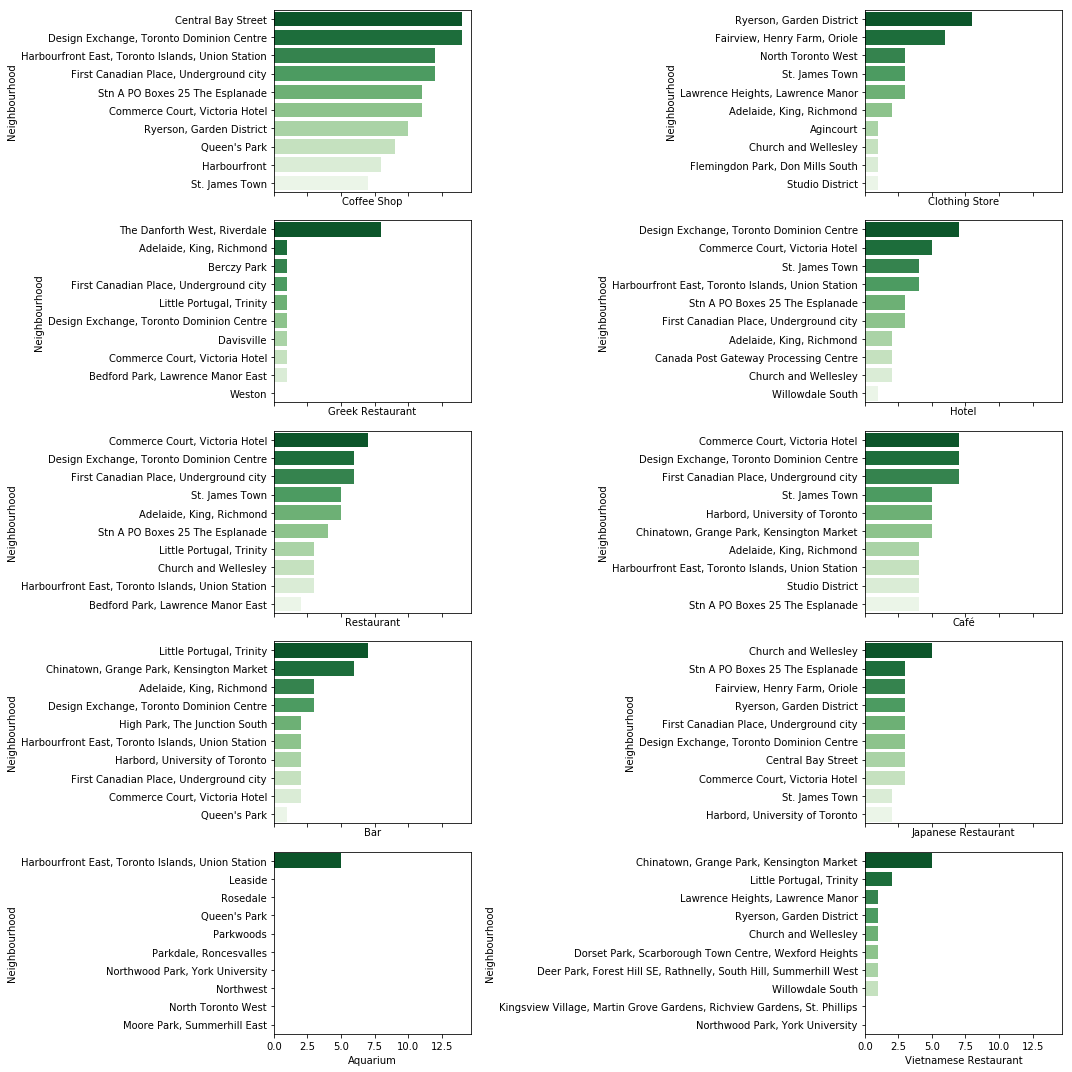

In [28]:
venue_top10_list = venue_top10.index.values.tolist()
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(15,15), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = toronto_grouped1[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Greens", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

## Checking top 10 venues in each neighbourhood 

## ***Note: these are the top 10 categories within each neighbourhood*** 

In [29]:
num_top_venues =10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
Neighbourhood = ['Neighbourhood']
top_venues = []
for ind in np.arange(num_top_venues):
    try:
        top_venues.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venues.append('{}th Most Common Venue'.format(ind+1))

        columns = Neighbourhood + top_venues

common_venues = pd.DataFrame(columns=columns)
common_venues['Neighbourhood'] = toronto_grouped2['Neighbourhood']

for ind in np.arange(toronto_grouped2.shape[0]):
    row_categories = toronto_grouped2.iloc[ind,1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    common_venues.iloc[ind,1:] = row_categories_sorted.index.values[0:num_top_venues]


common_venues.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Thai Restaurant,Steakhouse,Bar,Concert Hall,Breakfast Spot,Pizza Place,Bakery
1,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Liquor Store,Fried Chicken Joint,Pizza Place,Sandwich Place,Fast Food Restaurant,Beer Store,Pharmacy,General Entertainment,Gay Bar
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Pub,Skating Rink,Pool,Pharmacy,Gym,Dumpling Restaurant,Drugstore


## ***6.2 Clustering***

In [30]:

toronto_grouped_clustering = toronto_grouped2.drop('Neighbourhood', 1)
toronto_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


In [31]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans =  KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([86,  1, 12]))

In [32]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = pd.merge(Toronto, common_venues, on='Neighbourhood', how='right')

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

print(toronto_merged.shape)
toronto_merged.head()

(99, 16)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,Park,Food & Drink Shop,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,Intersection,Coffee Shop,Portuguese Restaurant,Hockey Arena,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,0
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,Coffee Shop,Park,Pub,Bakery,Mexican Restaurant,Café,Theater,Yoga Studio,Shoe Store,Hotel,2
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Clothing Store,Furniture / Home Store,Accessories Store,Coffee Shop,Shoe Store,Miscellaneous Shop,Boutique,Event Space,Gift Shop,Vietnamese Restaurant,0
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,Coffee Shop,Park,Chinese Restaurant,Sushi Restaurant,Bank,Bar,Portuguese Restaurant,Café,Diner,Beer Bar,0


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## ***7. Conclusion and Discussion***

## ***7.1 Clusters***

### Cluster 0

In [41]:
required_column_indices = [2,5,6,7]
required_column = [list(toronto_merged.columns.values)[i] for i in required_column_indices]


In [46]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[1:10]]
print(cluster_0.shape[0])
cluster_0.head()


86


,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,Park,Food & Drink Shop,Yoga Studio,Donut Shop,Diner
1,North York,Victoria Village,43.725882,-79.315572,Intersection,Coffee Shop,Portuguese Restaurant,Hockey Arena,Yoga Studio
3,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Clothing Store,Furniture / Home Store,Accessories Store,Coffee Shop,Shoe Store
4,Downtown Toronto,Queen's Park,43.662301,-79.389494,Coffee Shop,Park,Chinese Restaurant,Sushi Restaurant,Bank
5,Scarborough,"Rouge, Malvern",43.806686,-79.194353,Fast Food Restaurant,Drugstore,Diner,Discount Store,Distribution Center


In [47]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False)[0:10])
    print("---------------------------------------------")

Stn A PO Boxes 25 The Esplanade                                                                               1
Downsview Central                                                                                             1
Caledonia-Fairbanks                                                                                           1
Berczy Park                                                                                                   1
Lawrence Park                                                                                                 1
Davisville                                                                                                    1
L'Amoreaux West                                                                                               1
Clarks Corners, Sullivan, Tam O'Shanter                                                                       1
Maryvale, Wexford                                                                                       

### Cluster 1

In [48]:
cluster_1 =toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[1:10]]
print(cluster_1.shape[0])
cluster_1.head(5)

1


,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
74,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724,Pizza Place,Sandwich Place,Bus Line,Mobile Phone Shop,Dessert Shop


In [49]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips    1
Name: Neighbourhood, dtype: int64
---------------------------------------------
Pizza Place    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Sandwich Place    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bus Line    1
Name: 3rd Most Common Venue, dtype: int64
---------------------------------------------


### Cluster 2

In [51]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[1:10]]
print(cluster_2.shape[0])
cluster_2.head(5)

12


,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,Coffee Shop,Park,Pub,Bakery,Mexican Restaurant
13,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Café,Restaurant,Italian Restaurant,Hotel
16,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Spa,Mexican Restaurant,Electronics Store,Breakfast Spot,Rental Car Location
38,North York,"CFB Toronto, Downsview East",43.737473,-79.464763,Airport,Park,Yoga Studio,Drugstore,Diner
40,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,Coffee Shop,Café,Hotel,Restaurant,Seafood Restaurant


In [52]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

The Annex, North Midtown, Yorkville                                                               1
Guildwood, Morningside, West Hill                                                                 1
Harbourfront                                                                                      1
Design Exchange, Toronto Dominion Centre                                                          1
St. James Town                                                                                    1
Cabbagetown, St. James Town                                                                       1
Dorset Park, Scarborough Town Centre, Wexford Heights                                             1
Canada Post Gateway Processing Centre                                                             1
Rosedale                                                                                          1
CFB Toronto, Downsview East                                                                       1


## 7.2 Discussion

The exploration and clustering analysis of Toronto neighbourhoods shows that Toronto has a very uniform neighbourhood type around %86 of the neighbourhoods have similar facilities.

<img src="https://www.elsetge.cat/myimg/f/41-411494_lu-alien-aesthetic-art-et-design-cool-wallpaper.png" />